In [1]:
%cd ./drive/MyDrive/RLWorms_Data/CrossEvals/
!ls

/content/drive/MyDrive/RLWorms_Data/CrossEvals
'281 with 301'	'301 with 352'	 Crosseval_far.svg    __pycache__
'281 with 352'	'352 with 281'	 Crosseval_near.svg   SAC.py
'301 with 281'	'352 with 301'	 Crossevals.ipynb     utils.py


In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import SAC as sac
from utils import *
import torch

from google.colab import output

In [ ]:
tdict = {
  'left':[380,-960],
  'right':[1780,-960],
  'up':[1080,-360],
  'down':[1080,-1560],
  'mid':[1080,-960]
    }

#281 cross evals

In [ ]:
def load_ens(line_path, suffix, n_agents=30):
  frames = 15
  nrns = 64

  polnet = sac.DiscretePolicy(frames*6, 2, 64, dropout=0.0)
  actors = [sac.DiscretePolicy(frames*6,2,64,dropout=0.0) for i in range(n_agents)]

  for i in range(n_agents):
    actor_path = f'{line_path}_s{i}_{suffix}_'
    actors[i].load_state_dict(torch.load(actor_path, map_location=torch.device('cpu')))
    #ens = Ensemble(actors)
  return actors

def load_critics(line_path):
  frames = 15
  nrns = 64
  n_agents = 30

  polnet = sac.DiscreteQNetwork(frames*6, 2, 64, dropout=0.0)
  actors = [sac.DiscreteQNetwork(frames*6,2,64,dropout=0.0) for i in range(n_agents)]

  for i in range(n_agents):
    actor_path = f'{line_path}_s{i}_fin_'
    actors[i].load_state_dict(torch.load(actor_path, map_location=torch.device('cpu')))
  return actors

In [ ]:
def fixit(traj,bounds):
  x, y = np.array(traj['x']), np.array(traj['y'])
  return np.invert(np.bitwise_or(np.bitwise_or(x<bounds[0],x>bounds[1]), 
                                 np.bitwise_or(y<bounds[2],y>bounds[3])))
  
def distance(pt1,pt2):
  return np.sqrt(np.sum(np.square(pt1-pt2), axis=1))

In [ ]:
ens = load_ens('./../Agents/sac_actor_L281_NoReg_t15_tr900_n64', f'e19_step0', n_agents=20)

In [ ]:
# radians, divide by 900

folder = './281 with 301/'
targets = [
           'down','left','up','right','up',
           'down','left','up','right','down'
]

mins, maxes = [],[]
for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)
  
  break

In [ ]:
traj.keys()

dict_keys(['x', 'y', 'body', 'head'])

In [ ]:
x = np.array(traj['x']) / 900
y = np.array(traj['y']) / 900
body = np.array(traj['body']) / 180 * np.pi
head = np.array(traj['head']) / 180 * np.pi

actions = []

for i in range(len(x)-15): 
  state = torch.tensor([np.sin(body[i:i+15]), np.cos(body[i:i+15]),
                np.sin(head[i:i+15]), np.cos(head[i:i+15]),
                x[i:i+15], y[i:i+15]], dtype=torch.float).view(1,-1)

  action_ens = []
  for actor in ens:
    action = actor(state)[1].detach().numpy()[0,1]
    action_ens.append(action)
  actions.append(np.round(sum(action_ens) / 20))

actions = [0. for _ in range(15)] + actions

0
1
2
3
4
5
6
7
8
9
10


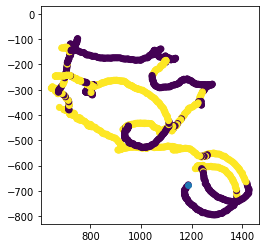

In [ ]:
# Gets the numbers for closest distance to target.

folder = './352 with 301/'

mins, maxes = [],[]
for i, fil in enumerate(sorted(os.listdir(folder))):

  print(i)

  # Load the trajectory
  if 'info' in fil or 'track' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)


    # Getting the light
    x = np.array(traj['x']) / 900
    y = np.array(traj['y']) / 900
    body = np.array(traj['body']) / 180 * np.pi
    head = np.array(traj['head']) / 180 * np.pi

    actions = []

    for t in range(len(x)-15): 
      state = torch.tensor([np.sin(body[t:t+15]), np.cos(body[t:t+15]),
                    np.sin(head[t:t+15]), np.cos(head[t:t+15]),
                    x[t:t+15], y[t:t+15]], dtype=torch.float).view(1,-1)

      action_ens = []
      for actor in ens:
        action = actor(state)[1].detach().numpy()[0,1]
        action_ens.append(action)
      actions.append(np.round(sum(action_ens) / 20))

    actions = [0. for _ in range(15)] + actions


    # Plot the trajectories
    plt.clf()
    plt.plot(traj['x'][0], traj['y'][0], 'o')
    plt.scatter(traj['x'], traj['y'], c=actions)
    plt.axis('square')
    plt.savefig(f'./{folder}/track{i}.svg')

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
mins = [483.8026457141383, 872.6625923001397, 804.8068091163245, 385.24018481980823, 650.5451560037935, 658.368437882619, 842.947210684038, 518.2991414231747, 545.4686058793851, 729.5436930026879] 
maxes = [763.5738340199983, 1448.7322043773308, 1416.0102400759679, 562.1761289845025, 750.1799784051824, 1415.4327960026926, 1611.775728815892, 818.7044643826, 900.7108304000791, 797.3863555391451]

print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

1.3524342660054394 0.10273057258668619
2.184308866875706 0.23676450071263988


In [4]:
l281_w_301 = np.array([483.8026457141383, 872.6625923001397, 804.8068091163245, 385.24018481980823, 650.5451560037935, 658.368437882619, 842.947210684038, 518.2991414231747, 545.4686058793851, 729.5436930026879]) / 480
l281_w_352 = np.array([871.2204083927327, 919.8260705155078, 747.572070104281, 958.4257926412456, 744.3251977462539, 602.0406962988466, 722.4133165992997, 618.1278184971131, 541.00369684504, 552.0443822737444]) / 480
l301_w_281 = np.array([742.3233796668403, 868.159547548721, 878.185060223641, 990.2065441108739, 705.5501399617181, 632.3140042731934, 470.73665674132496, 535.0813022335951, 629.2288931700451, 639.9320276404362]) / 480
l301_w_352 = np.array([550.2045074333724, 267.54065111679756, 105.47511554864494, 588.9422722134997, 154.8709139896837, 461.29925211298576, 365.65694304908254, 407.84801090602366, 605.2974475412894, 677.6761763556397]) / 480
l352_w_281 = np.array([94.41398201537736, 115.52056094046635, 597.6495628710859, 312.7746792820672, 895.806340678609, 899.9627770080272, 51.22499389946279, 703.56307464221, 932.6762568008259, 625.1663778547276]) / 480
l352_w_301 = np.array([182.58422713914803, 1.0, 17.029386365926403, 91.3892772703669, 2.23606797749979, 24.596747752497688, 546.0567736050896, 404.2425014765271, 66.0, 3.605551275463989]) / 480


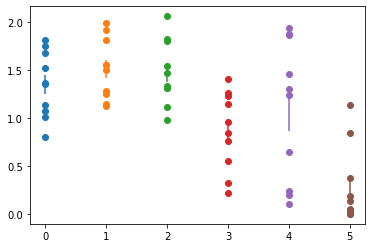

In [7]:
plt.scatter(np.zeros(10), l281_w_301)
plt.errorbar(0, 1.352, yerr=0.103)
plt.scatter(np.zeros(10)+1, l281_w_352)
plt.errorbar(1, 1.516, yerr=0.094)

plt.scatter(np.zeros(10)+2, l301_w_281)
plt.errorbar(2, 1.477, yerr=0.102)
plt.scatter(np.zeros(10)+3, l301_w_352)
plt.errorbar(3, 0.872, yerr=0.122)

plt.scatter(np.zeros(10)+4, l352_w_281)
plt.errorbar(4, 1.090, yerr=0.220)
plt.scatter(np.zeros(10)+5, l352_w_301)
plt.errorbar(5, 0.279, yerr=0.120)

plt.savefig('CrossEval bar graph.svg')

[871.2204083927327, 919.8260705155078, 747.572070104281, 958.4257926412456, 744.3251977462539, 602.0406962988466, 722.4133165992997, 618.1278184971131, 541.00369684504, 552.0443822737444] 
 [1498.7788362530343, 1135.867950071662, 1381.9352372669277, 1239.7580409095963, 1405.6094763482495, 1437.344774227812, 1451.6531954981533, 1090.5008023839323, 1474.0573258866157, 794.0510059183856]
1.5160415520654305 0.09431563175784768
2.6894909676592436 0.14116988933409727


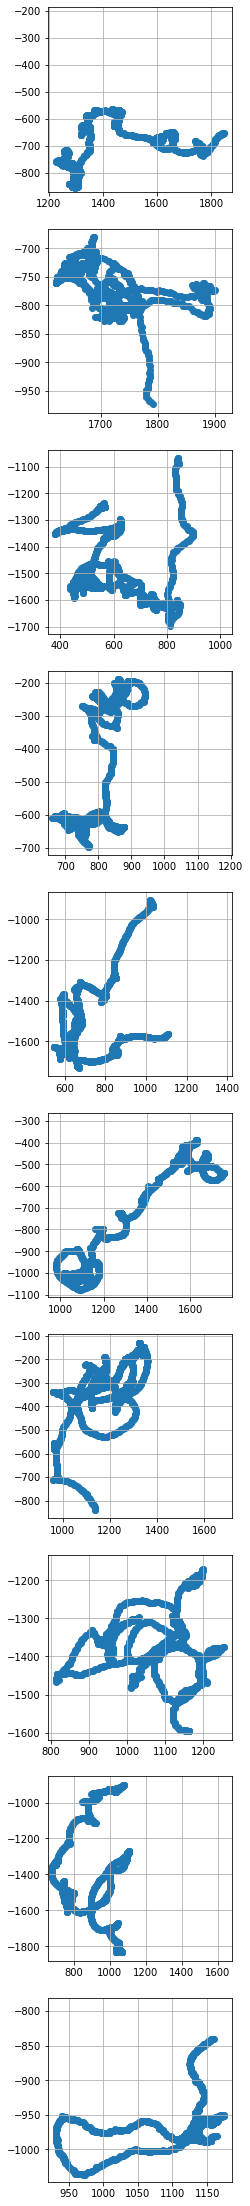

In [ ]:
folder = './281 with 352/'
targets = [
           'left','down','up','right','right',
           'left','down','right','up','left'
]
corrections = [
               [1000,2000,-1000,-200],None,None,None,None,
               [800,1800,-1200,-200],None,None,None,None
]

fig,ax = plt.subplots(10)
fig.set_size_inches(8,40)

mins, maxes = [], []

for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)

    # Correct bounds if necessary
    if corrections[i] is not None:
      fixed = fixit(traj,corrections[i])
    else:
      fixed = np.ones(len(traj['x']), dtype=bool)

    # Get indices
    pts = np.vstack([traj['x'],traj['y']]).T
    tester = distance(pts[fixed], np.broadcast_to(tdict[targets[i]], pts[fixed].shape))
    mins.append(min(tester))
    maxes.append(max(tester))

    # Plot the trajectories
    ax[i].scatter(np.array(traj['x'])[fixed], np.array(traj['y'])[fixed])
    ax[i].axis('square')
    ax[i].grid();

print(mins,'\n',maxes)
print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

#301 cross evals

[742.3233796668403, 868.159547548721, 878.185060223641, 990.2065441108739, 705.5501399617181, 632.3140042731934, 470.73665674132496, 535.0813022335951, 629.2288931700451, 639.9320276404362] 
 [1002.5607213530759, 1412.2039512761603, 924.1888335183454, 1443.6110972142046, 834.3170860050752, 1380.8884821012882, 735.1360418317144, 1268.8112546789614, 1236.6183728216236, 1471.5447665633553]
1.4774411574104973 0.1016756765136502
2.439558459867459 0.1709564617413838


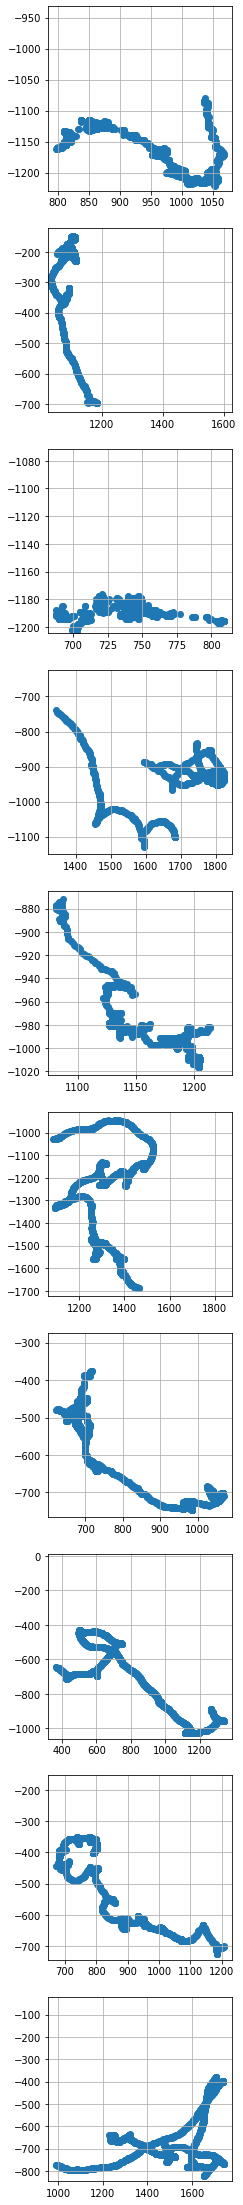

In [ ]:
folder = './301 with 281/'
targets = [
           'right','down','up','left','left',
           'up','left','down','right','left'
]
corrections = [
               None,None,None,None,None,
               None,None,None,None,None
]

fig,ax = plt.subplots(10)
fig.set_size_inches(8,40)
mins, maxes = [], []

for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)

    # Correct bounds if necessary
    if corrections[i] is not None:
      fixed = fixit(traj,corrections[i])
    else:
      fixed = np.ones(len(traj['x']), dtype=bool)

    # Get indices
    pts = np.vstack([traj['x'],traj['y']]).T
    tester = distance(pts[fixed], np.broadcast_to(tdict[targets[i]], pts[fixed].shape))
    mins.append(min(tester))
    maxes.append(max(tester))

    # Plot the trajectories
    ax[i].scatter(np.array(traj['x'])[fixed], np.array(traj['y'])[fixed])
    ax[i].axis('square')
    ax[i].grid();

print(mins,'\n',maxes)
print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

[550.2045074333724, 267.54065111679756, 105.47511554864494, 588.9422722134997, 154.8709139896837, 461.29925211298576, 365.65694304908254, 407.84801090602366, 605.2974475412894, 677.6761763556397] 
 [947.1219562442843, 453.0298003443041, 537.1750180341598, 1081.7120688981888, 500.8492787256462, 1085.3239147830477, 562.9653630553127, 598.3886696788301, 813.177717353347, 787.1619909523071]
0.8718356854722956 0.12209709935281793
1.5347720370977977 0.1500091035583468


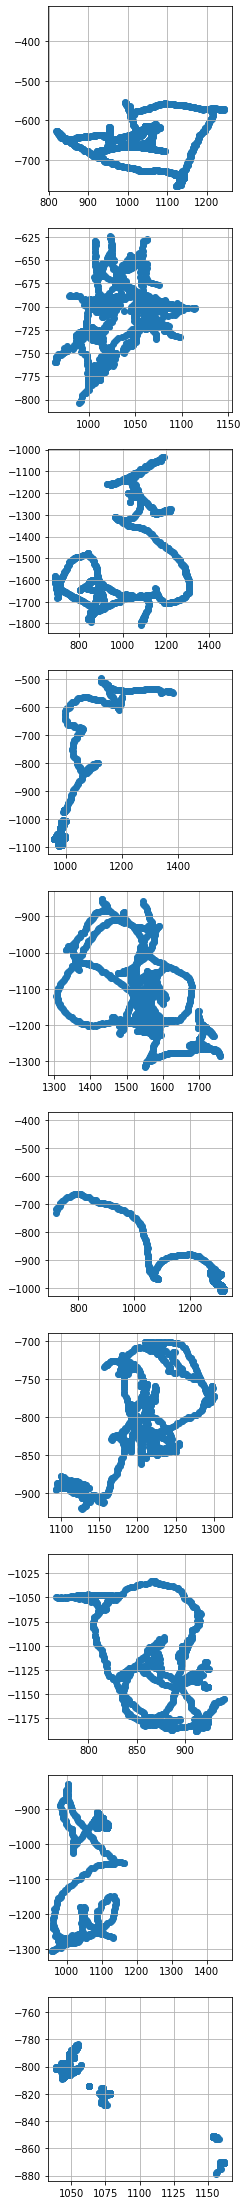

In [ ]:
folder = './301 with 352/'
targets = [
           'left','up','down','left','right',
           'right','up','down','left','left'
]
corrections = [
               None,None,None,None,None,
               None,None,None,None,None
]

fig,ax = plt.subplots(10)
fig.set_size_inches(8,40)
mins, maxes = [], []

for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)

    # Correct bounds if necessary
    if corrections[i] is not None:
      fixed = fixit(traj,corrections[i])
    else:
      fixed = np.ones(len(traj['x']), dtype=bool)

    # Get indices
    pts = np.vstack([traj['x'],traj['y']]).T
    tester = distance(pts[fixed], np.broadcast_to(tdict[targets[i]], pts[fixed].shape))
    mins.append(min(tester))
    maxes.append(max(tester))

    # Plot the trajectories
    ax[i].scatter(np.array(traj['x'])[fixed], np.array(traj['y'])[fixed])
    ax[i].axis('square')
    ax[i].grid();

print(mins,'\n',maxes)
print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

# 352 cross evals

[94.41398201537736, 115.52056094046635, 597.6495628710859, 312.7746792820672, 895.806340678609, 899.9627770080272, 51.22499389946279, 703.56307464221, 932.6762568008259, 625.1663778547276] 
 [552.4201299735555, 1226.1749467347634, 729.5985197353405, 626.706470367109, 1225.9857258549139, 959.6108586296843, 929.7101698916712, 1032.2344694884007, 1586.445712906685, 1352.3327992768643]
1.0893247095818457 0.21989041462863693
2.129420792262289 0.20684799401652423


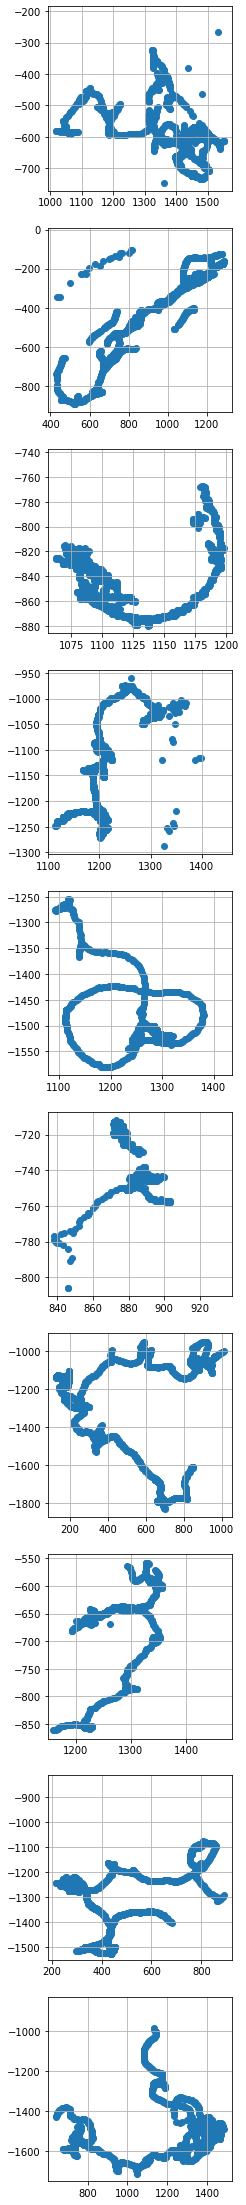

In [ ]:
folder = './352 with 281/'
targets = [
           'up','left','right','down','up',
           'right','left','down','right','up'
]
corrections = [
               [1000,1600,-800,-250],[400,1300,-1000,-100],[1000,1200,-1000,-600],[1000,1400,-1300,-900],None,
               [500,1000,-1000,-600],None,[1000,1500,-1000,-400],[0,1000,-1600,-200],[0,1500,-1800,-800]
]

fig,ax = plt.subplots(10)
fig.set_size_inches(8,40)
mins, maxes = [], []

for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)

    # Correct bounds if necessary
    if corrections[i] is not None:
      fixed = fixit(traj,corrections[i])
    else:
      fixed = np.ones(len(traj['x']), dtype=bool)

    # Get indices
    pts = np.vstack([traj['x'],traj['y']]).T
    tester = distance(pts[fixed], np.broadcast_to(tdict[targets[i]], pts[fixed].shape))
    mins.append(min(tester))
    maxes.append(max(tester))

    # Plot the trajectories
    ax[i].scatter(np.array(traj['x'])[fixed], np.array(traj['y'])[fixed])
    ax[i].axis('square')
    ax[i].grid();

print(mins,'\n',maxes)
print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

[182.58422713914803, 1.0, 17.029386365926403, 91.3892772703669, 2.23606797749979, 24.596747752497688, 546.0567736050896, 404.2425014765271, 66.0, 3.605551275463989] 
 [919.3524895272759, 872.1479232332093, 518.683911452823, 614.9967479588815, 668.5215030199104, 678.8320852758803, 865.9018420121301, 1264.796030986815, 684.2835669515964, 492.4895937986913]
0.2789042776796915 0.1195561776961277
1.5791678529619195 0.1436556706752788


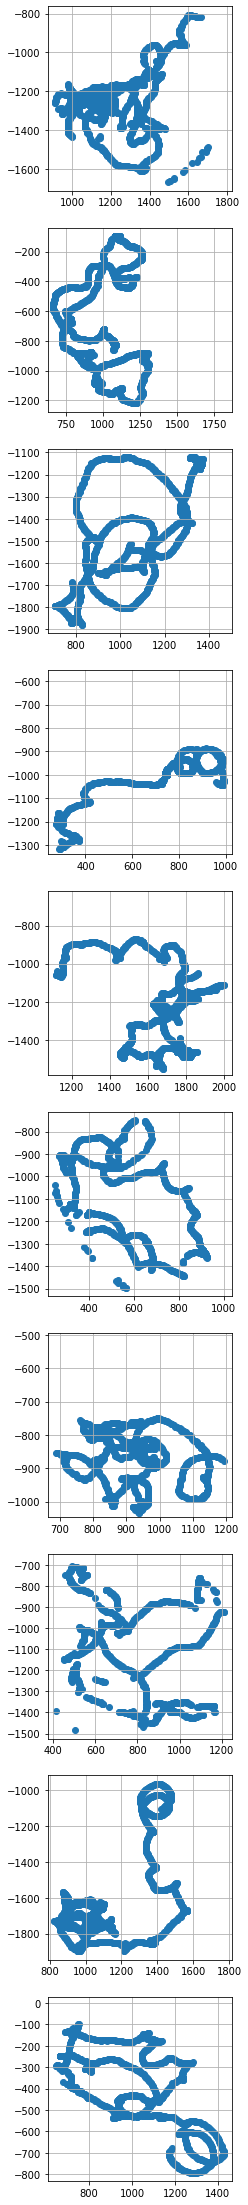

In [ ]:
folder = './352 with 301/'
targets = [
           'right','up','down','left','right',
           'left','down','up','down','up'
]
corrections = [
               [800,1700,-1800,-600],None,None,[250,1250,-1400,-600],None,
              [250,1000,-1500,-750],None,[400,1250,-1500,-600],None,None
]

fig,ax = plt.subplots(10)
fig.set_size_inches(8,40)
mins, maxes = [], []

for i, fil in enumerate(sorted(os.listdir(folder))):

  # Load the trajectory
  if 'info' in fil:
    pass
  else:
    #print(fil)
    with open(f'{folder}{fil}','rb') as f:
      traj = pickle.load(f)

    # Correct bounds if necessary
    if corrections[i] is not None:
      fixed = fixit(traj,corrections[i])
    else:
      fixed = np.ones(len(traj['x']), dtype=bool)

    # Get indices
    pts = np.vstack([traj['x'],traj['y']]).T
    tester = distance(pts[fixed], np.broadcast_to(tdict[targets[i]], pts[fixed].shape))
    mins.append(min(tester))
    maxes.append(max(tester))

    # Plot the trajectories
    ax[i].scatter(np.array(traj['x'])[fixed], np.array(traj['y'])[fixed])
    ax[i].axis('square')
    ax[i].grid();

print(mins,'\n',maxes)
print(np.mean(mins)/480,np.std(mins)/(np.sqrt(10)*480))
print(np.mean(maxes)/480,np.std(maxes)/(np.sqrt(10)*480))

# Compiled data

## Nearest approach

|          | 281 agent        | 301 agent        | 352 agent        |
|----------|------------------|------------------|------------------|
| 281 line | 0.28046(0.10384) | 1.35243(0.10273) | 1.51604(0.09432) |
| 301 line | 1.47744(0.10168) | 0.15608(0.12363) | 0.87184(0.12210) |
| 352 line | 1.08933(0.21989) | 0.27890(0.11956) | 0.49258(0.13953) |

## Furthest point

|          | 281 agent        | 301 agent        | 352 agent        |
|----------|------------------|------------------|------------------|
| 281 line | 1.96298(0.15737) | 2.18431(0.23676) | 2.68949(0.14117) |
| 301 line | 2.43956(0.17096) | 2.14739(0.20056) | 1.53477(0.15001) |
| 352 line | 2.12942(0.20685) | 1.57917(0.14366) | 2.05361(0.22565) |

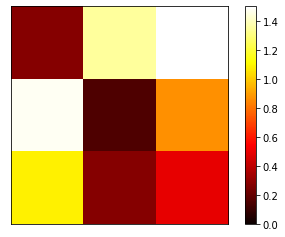

In [ ]:
# Cross eval: closest approach.
# Columns: agents
# Rows: line
plt.imshow([[0.28046, 1.35243, 1.51604],
            [1.47744, 0.15608, 0.87184],
            [1.08933, 0.27890, 0.49258]], cmap='hot', interpolation='nearest',
           vmin=0.,vmax=1.5)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.savefig('Crosseval_near.svg')

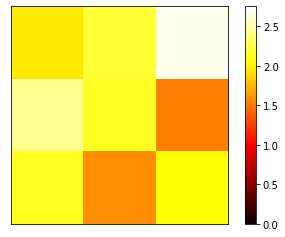

In [ ]:
# Cross eval: furthest distance
# Columns: agents
# Rows: line
plt.imshow([[1.96298, 2.18431, 2.68949],
            [2.43956, 2.14739, 1.53477],
            [2.12942, 1.57917, 2.05361]], cmap='hot', interpolation='nearest',
           vmin=0.,vmax=2.75)
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.savefig('Crosseval_far.svg')